In [125]:
using MPI
using CLIMA
using Logging
using CLIMA.Mesh.Topologies
using CLIMA.Mesh.Grids
using CLIMA.DGmethods
using CLIMA.DGmethods.NumericalFluxes
using CLIMA.MPIStateArrays
using CLIMA.LowStorageRungeKuttaMethod
using LinearAlgebra
using CLIMA.GenericCallbacks: EveryXWallTimeSeconds, EveryXSimulationSteps
using CLIMA.ODESolvers
ENV["GKS_ENCODING"] = "utf-8"
using Plots
gr()

Plots.GRBackend()

In [126]:
include("soilmodel.jl")
MPI.Initialized() || MPI.Init()
mpicomm = MPI.COMM_WORLD

MPI.Comm(MPI.MPI_Comm(0x0000000125f91410))

In [154]:
# set up domain
topl = StackedBrickTopology(mpicomm, (0:1,0:1,0:-1:-10); 
    periodicity = (true,true,false),
    boundary=((0,0),(0,0),(1,2)))
grid = DiscontinuousSpectralElementGrid(topl, FloatType = Float64, DeviceArray = Array, polynomialorder = 5)

m = SoilModel(1.0,1.0,1.0,20.0,10.0)

# Set up DG scheme
dg = DGModel( # 
  m, # "PDE part"
  grid,
  CentralNumericalFluxNonDiffusive(), # penalty terms for discretizations
  CentralNumericalFluxDiffusive(),
  CentralGradPenalty())


Δ = min_node_distance(grid)
CFL_bound = (Δ^2 / (2m.λ/(m.ρ*m.c)))
dt = CFL_bound*0.5 # TODO: provide a "default" timestep based on  Δx,Δy,Δz

0.0034499375508678866

In [155]:
function plotstate(grid, Q)
    # TODO:
    # this currently uses some internals: provide a better way to do this
    gridg = reshape(grid.vgeo[(1:6^2:6^3),CLIMA.Mesh.Grids.vgeoid.x3id,:],:)
    Qg = reshape(Q.data[(1:6^2:6^3),1,:],:)
    plot(Qg, gridg, ylabel="depth", xlabel="ρcT", xlimit=(0,40), yticks=-10:1:0)
end

plotstate (generic function with 1 method)

sum(Q.data) / 6 ^ 3 = 100.0


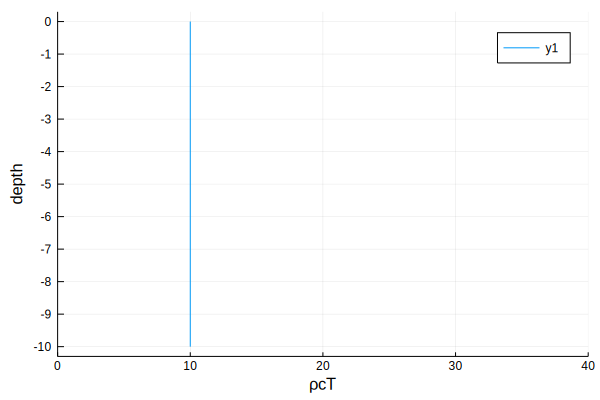

In [156]:
# state variable
Q = init_ode_state(dg, Float64(0))


@show sum(Q.data) / (6^3)
# initialize ODE solver
lsrk = LSRK54CarpenterKennedy(dg, Q; dt = dt, t0 = 0)
plotstate(grid, Q)

In [157]:
# run model
t = solve!(Q, lsrk; timeend=1000dt)

3.4499375508678867

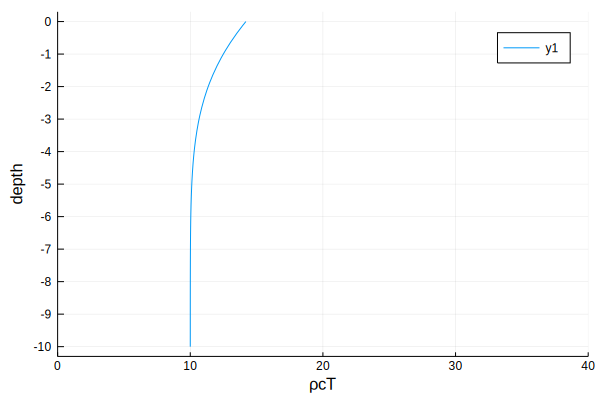

In [158]:
plotstate(grid, Q)

In [159]:
# compute emprical d(ρcT)/dt to compare with BC
(sum(Q.data) / (6^3) - 100.0) / t

2.016103351071271